# **Point Net - Classification**

In this notebook, we will use the classification version of point net to classify objects from the shapenet dataset

In [1]:
import os
import sys
import re
from glob import glob
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
from torchmetrics.classification import MulticlassMatthewsCorrCoef
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.nn.functional import kl_div


import open3d as o3


import torch_geometric.transforms as T
from torch_geometric.datasets import ModelNet
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MLP, fps, global_max_pool, radius
from torch_geometric.nn.conv import PointConv

#from open3d.web_visualizer import draw # for non Colab
#sys.path.append('../../PointNet-VAE/src')
sys.path.append('../src')

from models.utils import PointsTo3DShape
from models.PointNetEncoder import PointNetBackbone
from utils.calculate_loss import ChamferDistanceLoss
from models.PointCloudEncoder import PointCloudEncoder
from models.PointCloudDecoder import PointCloudDecoder, PointCloudDecoderSelf, PointCloudDecoderMLP
from models.AutoEncoder import AutoEncoder
from models.VAE import VAE
from data.dataset import DataModelNet
from utils.utils import *


from tqdm import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# TEMP for supressing pytorch user warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
print('MPS is build: {}'.format(torch.backends.mps.is_built()))
print('MPS Availability: {}'.format(torch.backends.mps.is_available()))
DEVICE = 'cuda' if torch.cuda.is_available() else 'mps'
print('Device is set to :{}'.format(DEVICE))
#torch.set_default_device(DEVICE)
torch.seed = 42

MPS is build: True
MPS Availability: True
Device is set to :mps


### Get the data

In [4]:
# General parameters
#NUM_TRAIN_POINTS = 8192
NUM_TEST_POINTS = 1024

NUM_POINTS = 1024
NUM_CLASSES = 16

# model hyperparameters
GLOBAL_FEATS = 1024
BATCH_SIZE = 32

EPOCHS = 1000
LR = 0.0001
REG_WEIGHT = 0.001 

LATENT_DIM = 128

Helpers for our dataset

In [5]:
# get class - label mappings
CATEGORIES = {
    'Bathtub': 0,
    'Bed': 1,
    'Chair': 2,
    'Desk': 3,
    'Dresser': 4,
    'Monitor': 5,
    'Night_Stand': 6,
    'Sofa': 7,
    'Table': 8,
    'Toilet': 9,
}


In [6]:
data = DataModelNet(
        data_path = "../../data/ModelNet10" ,
        pre_transform = T.NormalizeScale(),
        train_batch_size = 32,
        val_batch_size = 32,
        train_num_points = 1024,
        val_num_points = 1024,
)

In [7]:
data.setup()
train_loader = data.train_dataloader()
val_loader = data.val_dataloader()

In [8]:
points = next(iter(train_loader))[0].pos
PointsTo3DShape(points)
    

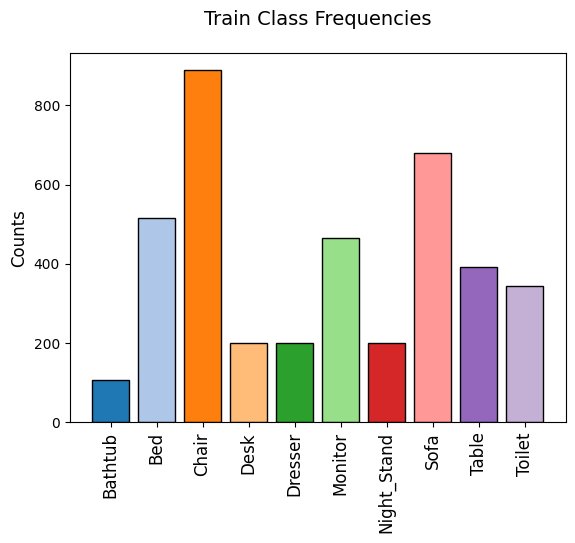

In [9]:
total_train_targets = []
for loader in train_loader:
    pos = loader.pos
    targets = loader.y
    total_train_targets += targets.reshape(-1).numpy().tolist()

total_train_targets = np.array(total_train_targets)

class_bins = np.bincount(total_train_targets)

plt.bar(list(CATEGORIES.keys()), class_bins, 
             color=mpl.cm.tab20(np.arange(0, NUM_CLASSES)),
             edgecolor='black')
plt.xticks(list(CATEGORIES.keys()), list(CATEGORIES.keys()), size=12, rotation=90)
plt.ylabel('Counts', size=12)
plt.title('Train Class Frequencies', size=14, pad=20);

In [10]:
encoder = PointCloudEncoder(latent_dim=LATENT_DIM, num_point=NUM_POINTS).to(DEVICE)
#encoder = PointNetBackbone(num_points=NUM_POINTS, num_global_feats=LATENT_DIM, local_feat=False).to(DEVICE)
decoder = PointCloudDecoderMLP(latent_dim=LATENT_DIM, num_hidden=3, num_point=NUM_POINTS).to(DEVICE)
autoencoder = AutoEncoder(encoder, decoder, device=DEVICE, latent_dim=LATENT_DIM).to(DEVICE)
vae = VAE(encoder, decoder, device=DEVICE, latent_dim=LATENT_DIM).to(DEVICE)

In [11]:
#MODEL_PATH = '../../pointnet_transferlearning/models/trained/vae_pointnet_runs/vae_conv_run_best/run5/cls_model_804_0.06466853033219065.pth'
#vae.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
#vae.train()

In [13]:
from utils.train import Trainer

model_run = Trainer(
        model=vae,
        criterion=ChamferDistanceLoss(),
        optimizer=optim.Adam(vae.parameters(), lr=0.001),
        encoder_type='ConvolutionEncoder',
        model_type='VAE',
        checkpoint='../models/checkpoints',
        experiment='trial',
        device='mps',
        kl_loss_weight = 0.00001)

In [14]:
model_run.fit(train_loader, val_loader, 1)

  0%|          | 0/1 [00:00<?, ?it/s]

# END OF TRAINING CYCLE

In [ ]:
# Define the loss function and optimizer
num_batch = len(train_loader)
best_metric=99999999999
chamfer_loss = ChamferDistanceLoss().to(DEVICE)
optimizer = optim.Adam(vae.parameters(), lr=0.001)

In [ ]:
# Training loop (you will need to load your point cloud dataset and preprocess it)
for epoch in range(EPOCHS):
    _loss = []
    _rc_loss = []
    _kl_loss = []
    for i, data in tqdm(enumerate(train_loader)):  # Iterate through your dataset
        optimizer.zero_grad()
        
        # Forward pass
        batch_size = data.y.shape[0]
        points = torch.stack([data[idx].pos for idx in range(batch_size)]).unsqueeze(1) ## If Convolution Encoder

        #points = torch.stack([data[idx].pos for idx in range(batch_size)]).transpose(2, 1) ## If PointNet Encoder
        targets = data.y
        
        points = points.to(DEVICE)
        targets = targets.to(DEVICE)



        #reconstructed_x = autoencoder(points)
        
        reconstructed_x, mu, logvar = vae(points)

        # Compute the reconstruction loss
        #loss_reconstruction = chamfer_loss(reconstructed_x, points.transpose(2, 1)) ## If PointNet Encoder is used
        loss_reconstruction = chamfer_loss(reconstructed_x, points.squeeze(1)) ## If Convolution Encoder
        #kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        kl_divergence = torch.mean(-0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim = 1), dim = 0)
        # Total loss is a combination of reconstruction loss and KL divergence loss

        #loss = loss_reconstruction
        loss = loss_reconstruction + 0.001*kl_divergence

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        #if i % 50 == 0:
        #    print('{}: {}/{} - loss: {} - KL Loss: {} - Reconst Loss: {}'.format(epoch, i, num_batch, loss.item(), kl_divergence.item(), loss_reconstruction.item()))
            #print('{}: {}/{} - loss: {}'.format(epoch, i, num_batch, loss.item()))

        _loss.append(loss.item())
        _rc_loss.append(loss_reconstruction.item())
        _kl_loss.append(kl_divergence.item())
    
    epoch_loss = np.mean(_loss)
    rc_loss = np.mean(_rc_loss)
    kl_loss = np.mean(_kl_loss)

    #print(f'Epoch: {epoch} - Loss: {epoch_loss:.4f} ')
    print('Epoch: {} - Loss: {} - Reconst Loss: {} - KL Loss: {}'.format(epoch, epoch_loss, rc_loss, kl_loss))
    torch.save(vae.state_dict(), '../models/trained/vae_pointnet_runs/cls_model_{}_{}.pth'.format(epoch, epoch_loss))
    #torch.save(autoencoder.state_dict(), '../models/trained/vae_pointnet_runs/cls_model_{}_{}.pth'.format(epoch, epoch_loss))

In [ ]:
from random import randrange

torch.cuda.empty_cache() # release GPU memory

# get random sample from test data 
random_idx = randrange(len(data.val_dataset))
print('Index: {}'.format(random_idx))
points, targets = data.val_dataset[random_idx].pos, data.val_dataset[random_idx].y
print(points.shape)


vae.eval()

with torch.no_grad():
    #norm_points = points.unsqueeze(0).transpose(2, 1).to(DEVICE)
    norm_points = points.unsqueeze(0).unsqueeze(1).to(DEVICE) ## If Convolution Encoder
    #norm_points = points.unsqueeze(0).transpose(2, 1).to(DEVICE) ## If PointNet Encoder
    print(norm_points.shape)

    targets = targets.squeeze().to(DEVICE)
    
    reconstructed_x, mu, logvar = vae(norm_points)
    #reconstructed_x = autoencoder(norm_points)

chamfer_loss(reconstructed_x.to(DEVICE), points.unsqueeze(1).to(DEVICE))

In [ ]:
PointsTo3DShape(points.cpu().numpy())


In [ ]:
PointsTo3DShape(reconstructed_x.squeeze(0).cpu().numpy())


In [ ]:
import pyvista as pv
point_cloud = pv.PolyData(reconstructed_x.squeeze(0).cpu().numpy())
mesh = point_cloud.reconstruct_surface()
mesh.plot(color='orange')
